In [1]:
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import layers, models, optimizers, regularizers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import os


2025-08-12 04:29:13.270617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754972953.461532      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754972953.516298      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# 定义预处理函数

# 归一化图像到 [0,1] 范围
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label
    
# 数据增强函数
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

# 设置seed
def set_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # GPU相关设置
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)
set_seed(10)

# 加载数据集
(train_ds, test_ds), ds_info = tfds.load(
    "eurosat/rgb",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

# 修正数据管道
def prepare_dataset(ds, batch_size=32, use_augment=False):  
    ds = ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
    if use_augment:  # 使用 use_augment 判断是否启用增强
        ds = ds.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)  
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# 创建数据加载器
train_ds = prepare_dataset(train_ds, batch_size=64, use_augment=True)  
test_ds = prepare_dataset(test_ds, batch_size=64)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/eurosat/rgb/incomplete.C14AN3_2.0.0/eurosat-train.tfrecord*...:   0%|     …

Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


I0000 00:00:1754973030.698371      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Class Counts: 10
Class Names: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


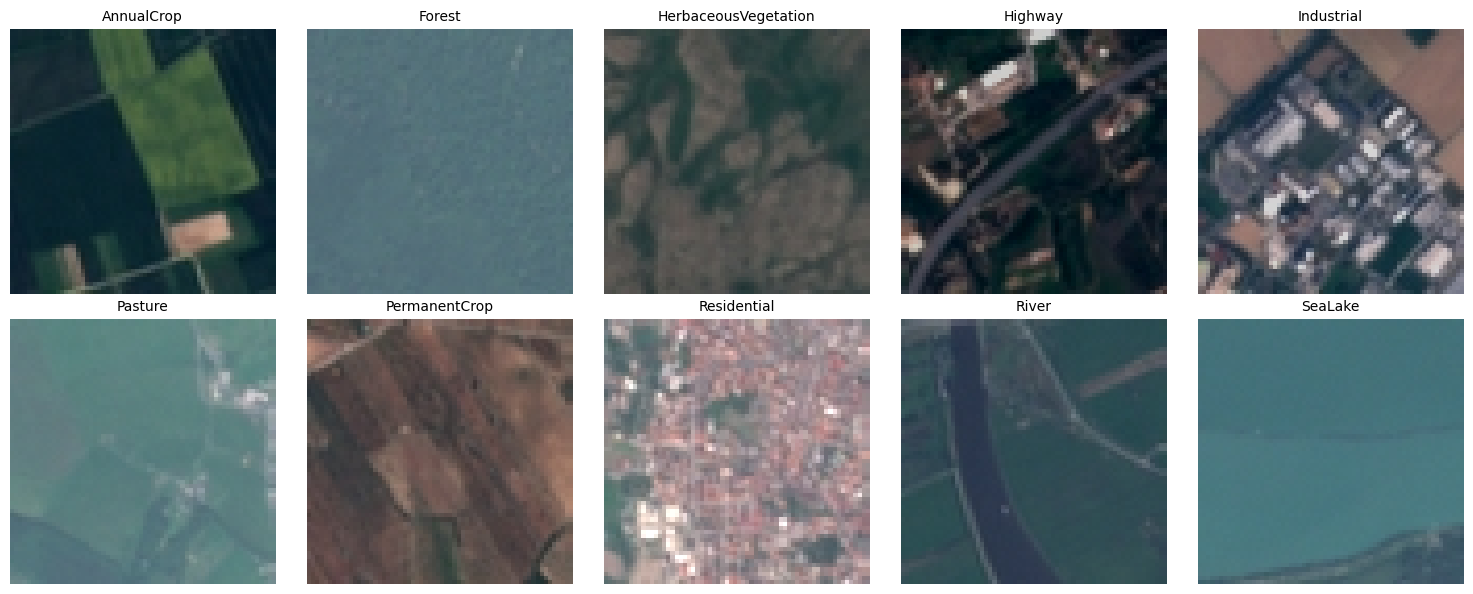

In [3]:
# 获取类别名称和数量
class_names = ds_info.features['label'].names
num_classes = len(class_names)
print("Class Counts:", num_classes)
print("Class Names:", class_names)

# 创建一个字典来存储每个类别的第一个样本
class_samples = {name: None for name in class_names}

# 遍历数据集直到每个类别都找到一个样本
for images, labels in train_ds.unbatch():
    label_name = class_names[labels.numpy()]
    if class_samples[label_name] is None:
        class_samples[label_name] = (images.numpy(), label_name)
    # 检查是否所有类别都已找到样本
    if all(sample is not None for sample in class_samples.values()):
        break

# 绘制每个类别的样本
cols = 5
rows = (num_classes + cols - 1) // cols
plt.figure(figsize=(15, 3 * rows))

for idx, (class_name, (image, _)) in enumerate(class_samples.items()):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(image)
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [4]:
def build_cnn_model(input_shape=(64, 64, 3), num_classes=10):
    model = models.Sequential([
        # 卷积块1 + 正则化
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, 
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.1),  # Dropout层

        # 卷积块2
        layers.Conv2D(64, (3, 3), activation='relu', 
                     kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        # 卷积块3
        layers.Conv2D(128, (2, 2), activation='relu'),
        layers.GlobalAveragePooling2D(),
        
        # 全连接层
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),  # 高Dropout防止过拟合
        layers.Dense(num_classes, activation='softmax')
    ])
    return model
    
model = build_cnn_model()
# 输出模型信息
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 13, 13, 128)         │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 89,290 (348.79 KB)

 Trainable params: 88,586 (346.04 KB)

 Non-trainable params: 704 (2.75 KB)

In [5]:
# 回调函数
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.h5", 
        save_best_only=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5,      # 学习率乘以0.5
        patience=3,      # 连续3次验证损失不下降时触发
        min_lr=1e-7     # 最小学习率下限
    )
]

# 编译模型
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.01),  # 初始学习率可稍大
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
# 训练
epochs = 100 # 存在早停策略，可设置较大值
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=epochs,
    callbacks=callbacks
)

# 评估测试集
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/100


E0000 00:00:1754973038.105231      19 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1754973038.849515     113 cuda_dnn.cc:529] Loaded cuDNN version 90300


338/338 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - accuracy: 0.4605 - loss: 1.5929 - val_accuracy: 0.2924 - val_loss: 2.6664 - learning_rate: 0.0100
Epoch 2/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6632 - loss: 1.0048 - val_accuracy: 0.3983 - val_loss: 1.9806 - learning_rate: 0.0100
Epoch 3/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7131 - loss: 0.8519 - val_accuracy: 0.3320 - val_loss: 2.2205 - learning_rate: 0.0100
Epoch 4/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7361 - loss: 0.7968 - val_accuracy: 0.5465 - val_loss: 1.3258 - learning_rate: 0.0100
Epoch 5/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7636 - loss: 0.7424 - val_accuracy: 0.4433 - val_loss: 1.7329 - learning_rate: 0.0100
Epoch 6/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.7872 - loss: 0.6861 - val_accuracy: 0.7833 - val_loss: 0.6822 - learning_rate: 0.0100
Epoch 7/100
338/338 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.7997 - loss: 0.6582

Setting epochs: 100
Actually epochs: 34


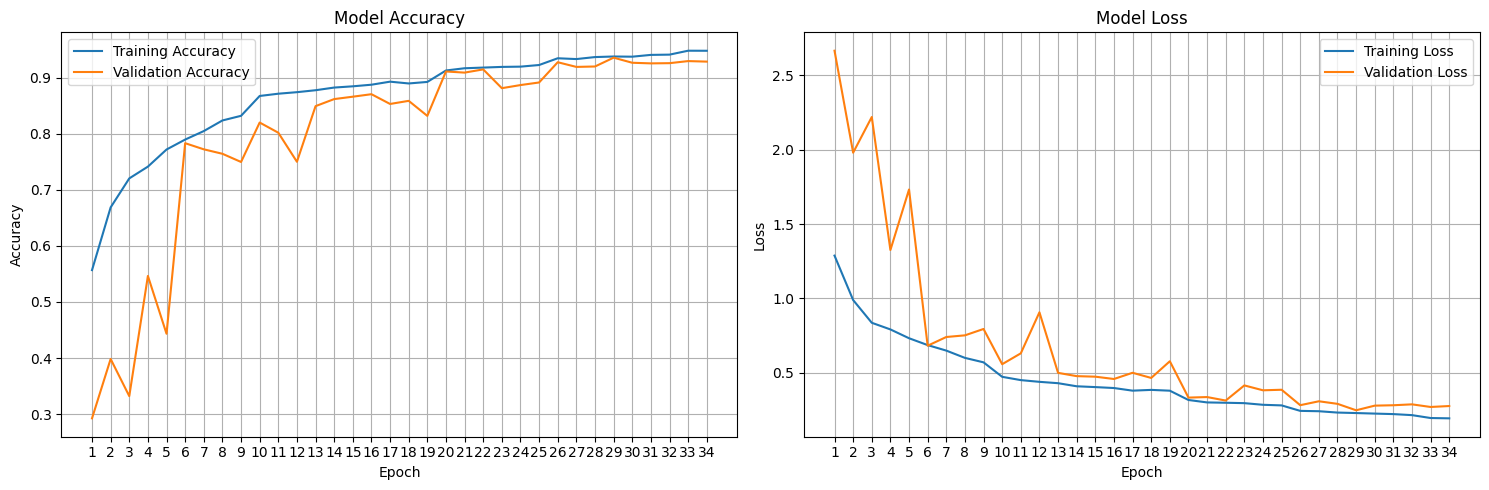

In [6]:
# 获取实际训练轮数
actual_epochs = len(history.history['accuracy'])
print("Setting epochs:",epochs)
print("Actually epochs:",actual_epochs)

# 绘制评测曲线（accuracy+loss）
plt.figure(figsize=(15, 5))

# Accuracy曲线
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.xticks(range(0, actual_epochs), range(1, actual_epochs+1))  # 使用actual_epochs
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss曲线
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.xticks(range(0, actual_epochs), range(1, actual_epochs+1))  # 使用actual_epochs
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.86      0.95      0.91       573
              Forest       0.97      0.99      0.98       575
HerbaceousVegetation       0.90      0.93      0.92       621
             Highway       0.91      0.85      0.88       504
          Industrial       0.96      0.94      0.95       501
             Pasture       0.96      0.93      0.95       397
       PermanentCrop       0.89      0.89      0.89       504
         Residential       0.98      0.97      0.98       608
               River       0.96      0.88      0.91       511
             SeaLake       0.98      0.99      0.98       606

            accuracy                           0.94      5400
           macro avg       0.94      0.93      0.93      5400
        weighted avg       0.94      0.94      0.94      5400


Per-Class Accuracy:
AnnualCrop               : 0.9529
Forest                   : 0.9930
HerbaceousVegeta

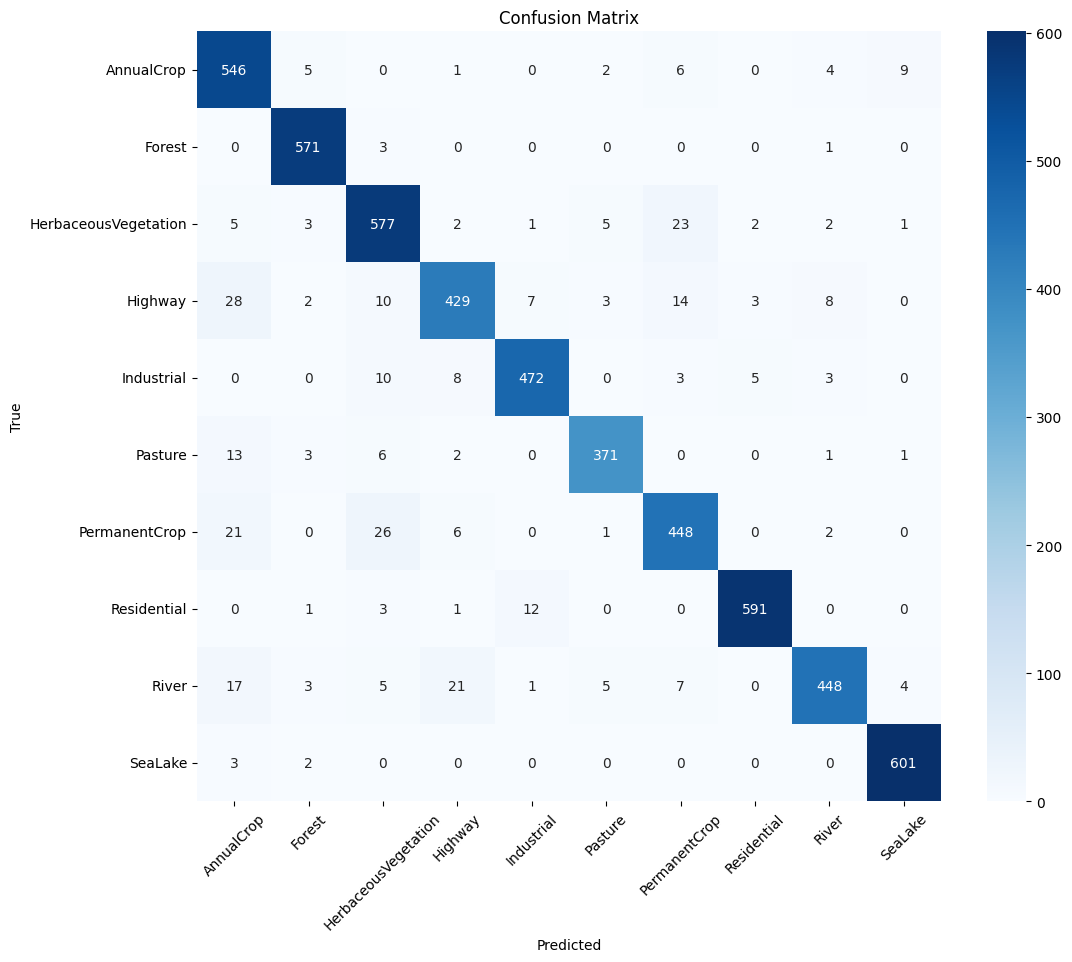

In [7]:
def evaluate_per_class_accuracy(model, test_ds, class_names):
    # 配置数据集线程参数
    options = tf.data.Options()
    options.experimental_threading.max_intra_op_parallelism = 1
    options.experimental_threading.private_threadpool_size = 4
    test_ds = test_ds.with_options(options)
    
    # 批量预测
    y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)
    y_pred = model.predict(test_ds, verbose=0).argmax(axis=1)
    
    # 打印分类报告
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))
    
    # 计算每个类别的准确率
    cm = confusion_matrix(y_true, y_pred)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)
    
    print("\nPer-Class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name:25s}: {class_accuracy[i]:.4f}")
    
    # 可视化混淆矩阵
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names,
                cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.show()
evaluate_per_class_accuracy(model, test_ds, class_names)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


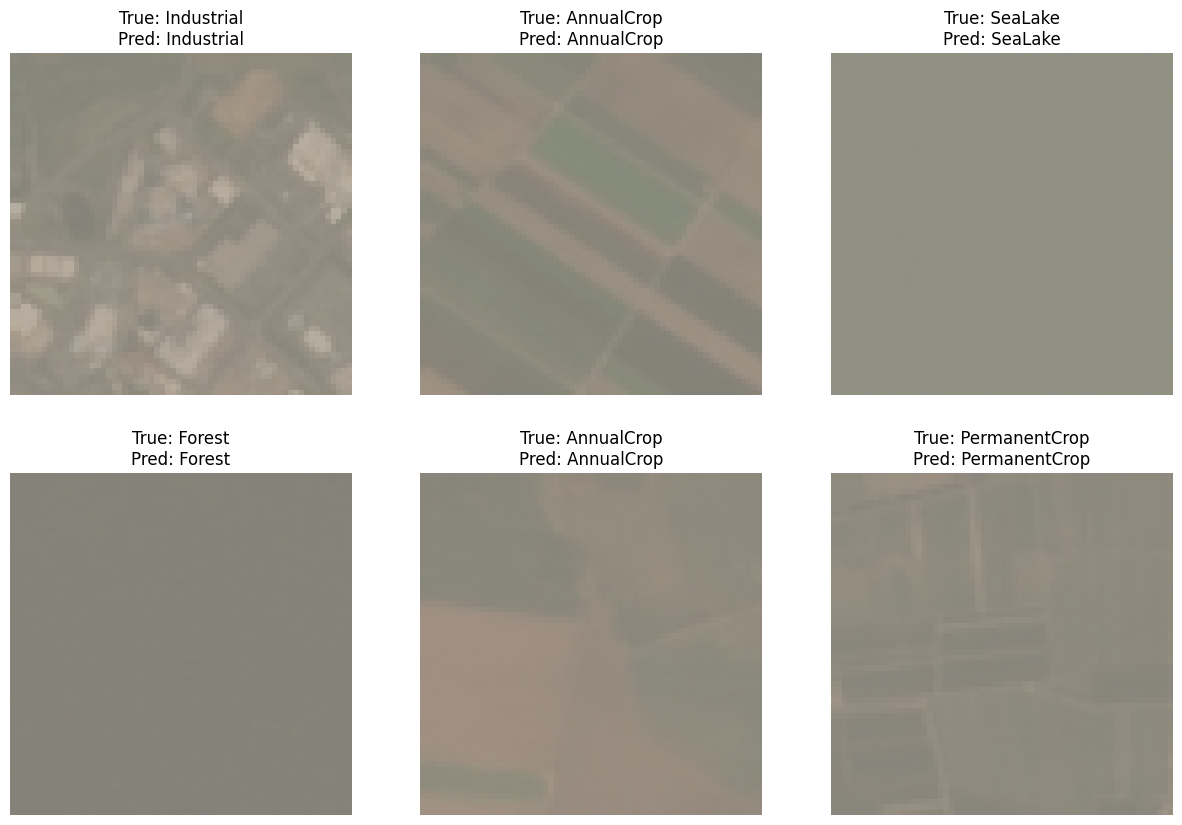

In [8]:
# 随机选择一批测试数据（6张图）并展示
def plot_predictions(model, test_dataset, class_names, num_images=6):
    plt.figure(figsize=(15, 10))
    shuffled_ds = test_dataset.shuffle(buffer_size=100)
    for images, labels in shuffled_ds.take(1):  # 取一个batch
        # 预测
        predictions = model.predict(images)
        pred_labels = tf.argmax(predictions, axis=1).numpy()
        
        # 绘制图像和预测结果
        for i in range(min(num_images, len(images))):
            plt.subplot(2, 3, i+1)
            img = images[i].numpy()
            img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406])  # 反归一化（ImageNet均值）
            img = np.clip(img, 0, 1)
            plt.imshow(img)
            plt.title(f"True: {class_names[labels[i]]}\nPred: {class_names[pred_labels[i]]}")
            plt.axis('off')
        plt.show()
        break  # 只取一个batch

# 展示预测
plot_predictions(model, test_ds, class_names)